# Урок 5. Feature Engineering, Feature Selection, part I

Продолжим работу с данными, которые были использованы в ДЗ 2 и 3, продолжим решать задачу обнаружения мошеннических транзакций, что позволит получить полное решение задачи / полный пайплайн.

**Задание 0:** выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

**Задание 1:** признак `TransactionDT` - это смещение в секундах относительно базовой даты. Базовая дата - `2017-12-01`, преобразовать признак `TransactionDT` в `datetime`, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

**Задание 2:** сделать конкатенацию признаков
* `card1 + card2`;
* `card1 + card2 + card_3 + card_5`;
* `card1 + card2 + card_3 + card_5 + addr1 + addr2`

Рассматривать их как категориальных признаки.

**Задание 3:** Сделать `FrequencyEncoder` для признаков `card1 - card6`, `addr1`, `addr2`.

**Задание 4:** Создать признаки на основе отношения: `TransactionAmt` к вычисленной статистике. Статистика - среднее значение / стандартное отклонение `TransactionAmt`, сгруппированное по `card1 - card6`, `addr1`, `addr2`, и по признакам, созданным в задании 2.

**Задание 5:** Создать признаки на основе отношения: D15 к вычисленной статистике. Статистика - среднее значение / стандартное отклонение D15, сгруппированное по `card1 - card6`, `addr1`, `addr2`, и по признакам, созданным в задании 2.

**Задание 6:** выделить дробную часть и целую часть признака `TransactionAmt` в два отдельных признака. После создать отдельных признак - логарифм от `TransactionAmt`

**Задание 7 (опция):** выполнить предварительную подготовку / очистку признаков `P_emaildomain` и `R_emaildomain` (что и как делать - остается на ваше усмотрение) и сделать Frequency Encoding для очищенных признаков.


In [124]:
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import metrics
from datetime import timedelta
from datetime import datetime

from sklearn.model_selection import train_test_split
# from sunbird.categorical_encoding import frequency_encoding
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import scipy.stats as st

import warnings
warnings.simplefilter("ignore")

import warnings
from tqdm import tqdm
from typing import List, Tuple

from scipy.stats import ttest_rel

# from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

warnings.simplefilter("ignore")
%matplotlib inline

In [125]:
public_df = pd.read_csv('../assignment2_data/assignment_2_train.csv')
private_df = pd.read_csv('../assignment2_data/assignment_2_test.csv')

In [126]:
print("public_df.shape = {} rows, {} cols".format(*public_df.shape))
print("private_df.shape = {} rows, {} cols".format(*private_df.shape))

public_df.shape = 180000 rows, 394 cols
private_df.shape = 100001 rows, 394 cols


In [127]:
public_df.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
len(public_df['TransactionID'].value_counts())

180000

In [129]:
public_df[['TransactionID','isFraud','TransactionDT','TransactionAmt','addr1','addr2']]

,TransactionID,isFraud,TransactionDT,TransactionAmt,addr1,addr2
0,2987000,0,86400,68.50,315.0,87.0
1,2987001,0,86401,29.00,325.0,87.0
2,2987002,0,86469,59.00,330.0,87.0
3,2987003,0,86499,50.00,476.0,87.0
4,2987004,0,86506,50.00,420.0,87.0
...,...,...,...,...,...,...
179995,3166995,0,3958217,39.00,272.0,87.0
179996,3166996,0,3958237,59.95,315.0,87.0
179997,3166997,0,3958241,34.00,330.0,87.0
179998,3166998,0,3958260,59.00,272.0,87.0


## Задание 0:

In [130]:
# Разделим выборки на тренировчную, тестовую и валидационную.

x_train, x_test = train_test_split(public_df.drop(["TransactionID", "isFraud"], axis=1), train_size=0.60, shuffle=False, random_state=1,)
y_train, y_test = train_test_split(public_df["isFraud"], train_size=0.60, shuffle=False, random_state=1,) # В данных имеется временная зависимость, поэтому пока перемешивать ничего не будем.

In [131]:
x_test, x_val = train_test_split(x_test, train_size=0.50, shuffle=False, random_state=1,)
y_test, y_val = train_test_split(y_test, train_size=0.50, shuffle=False, random_state=1,)

In [132]:
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_val.shape = {} rows, {} cols".format(*x_val.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 108000 rows, 392 cols
x_val.shape = 36000 rows, 392 cols
x_test.shape = 36000 rows, 392 cols


In [133]:
x_lb = private_df.drop(["TransactionID", "isFraud"], axis=1)
y_lb = private_df["isFraud"]

In [134]:
print("x_lb.shape = {} rows, {} cols".format(*x_lb.shape))

x_lb.shape = 100001 rows, 392 cols


In [135]:
# Получим список катероиальных и числовых признаков.

categorical = []
numerical = []
for col, value in x_train.iteritems():
    if value.dtype == 'object':
        categorical.append(col)
    else:
        numerical.append(col)

In [136]:
x_train[categorical].head(5)

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
# Выделим числовые и категриальные переменные. 

x_train[categorical]=x_train[categorical].astype('category')
x_test[categorical]=x_test[categorical].astype('category')
x_val[categorical]=x_val[categorical].astype('category')
x_lb[categorical]=x_lb[categorical].astype('category')

In [138]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    # "objective": "binary:logistic",
    "metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "reg_lambda": 50,
    "max_depth": 4,
    # "gamma": 4,
    # "nthread": 6,
    # "seed": 27,
    'random_state':1    
}

In [ ]:
# Написать pip-line для обучения модели. 

In [139]:
model = lgb.LGBMClassifier(**params)

model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_val, y_val), (x_val, y_val)],
    early_stopping_rounds=50,
    categorical_feature=categorical,
    # num_boost_round=10000,
    eval_metric="auc",
    verbose=20
)

[20]	valid_0's auc: 0.859651	valid_1's auc: 0.859651
[40]	valid_0's auc: 0.865949	valid_1's auc: 0.865949
[60]	valid_0's auc: 0.8706	valid_1's auc: 0.8706
[80]	valid_0's auc: 0.871479	valid_1's auc: 0.871479
[100]	valid_0's auc: 0.872493	valid_1's auc: 0.872493
[120]	valid_0's auc: 0.873055	valid_1's auc: 0.873055
[140]	valid_0's auc: 0.873847	valid_1's auc: 0.873847
[160]	valid_0's auc: 0.873269	valid_1's auc: 0.873269
[180]	valid_0's auc: 0.87396	valid_1's auc: 0.87396
[200]	valid_0's auc: 0.874522	valid_1's auc: 0.874522
[220]	valid_0's auc: 0.875116	valid_1's auc: 0.875116
[240]	valid_0's auc: 0.875126	valid_1's auc: 0.875126
[260]	valid_0's auc: 0.874849	valid_1's auc: 0.874849


LGBMClassifier(max_depth=4, metric='auc', n_estimators=10000,
               objective='binary', random_state=1, reg_lambda=50)

In [140]:
train_score =  roc_auc_score(y_train, model.predict(x_train))
val_score = roc_auc_score(y_val, model.predict(x_val))
test_score = roc_auc_score(y_test, model.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Val-score: {round(val_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.711, Val-score: 0.637, Test-score: 0.64


In [141]:
train_score =  roc_auc_score(y_train, model.predict_proba(x_train)[:,1])
val_score = roc_auc_score(y_val, model.predict_proba(x_val)[:,1])
test_score = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])

print(f"Train-score: {round(train_score, 3)}, Val-score: {round(val_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.939, Val-score: 0.876, Test-score: 0.894


## Задание 1:

**Задание 1:** признак `TransactionDT` - это смещение в секундах относительно базовой даты. Базовая дата - `2017-12-01`, преобразовать признак `TransactionDT` в `datetime`, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

In [142]:
def data_time_converter(data):
    
    data['TransactionDT'] = data['TransactionDT'].apply(lambda x: datetime(2017, 12, 1) + timedelta(seconds=x))
    data['Transaction_weekday'] = data['TransactionDT'].apply(lambda x: x.weekday())
    data['Transaction_year'] = data['TransactionDT'].apply(lambda x: x.date().year)
    data['Transaction_mounth'] = data['TransactionDT'].apply(lambda x: x.date().month)
    data['Transaction_day'] = data['TransactionDT'].apply(lambda x: x.date().day)
    data['Transaction_hour'] = data['TransactionDT'].apply(lambda x: x.time().hour)
    # return data

In [143]:
data_time_converter(x_train)
data_time_converter(x_test)
data_time_converter(x_val)
data_time_converter(x_lb)

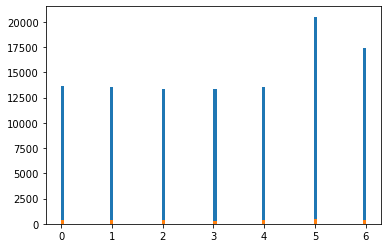

In [144]:
plt.hist(x_train.loc[(y_train==0,'Transaction_weekday')], 100)
plt.hist(x_train.loc[(y_train==1,'Transaction_weekday')], 100)
# plt.hist(train_df.loc[((train_df['isFraud']==1) &  (train_df['TransactionDT'][:10000]),'TransactionDT')], 100)
plt.show()

In [145]:
x_train.loc[(y_train==0,'Transaction_weekday')].value_counts()

5    20512
6    17416
0    13653
1    13541
4    13531
3    13333
2    13325
Name: Transaction_weekday, dtype: int64

In [146]:
x_train.loc[(y_train==1,'Transaction_weekday')].value_counts()

5    495
6    418
1    399
4    378
0    354
2    329
3    316
Name: Transaction_weekday, dtype: int64

## Задание 2:

In [147]:
# **Задание 2:** сделать конкатенацию признаков
# * `card1 + card2`;
# * `card1 + card2 + card_3 + card_5`;
# * `card1 + card2 + card_3 + card_5 + addr1 + addr2`

# Рассматривать их как категориальных признаки.

In [148]:
x_train[['card1','card2', 'card3','card5', 'addr1','addr2']]

,card1,card2,card3,card5,addr1,addr2
0,13926,NaN,150.0,142.0,315.0,87.0
1,2755,404.0,150.0,102.0,325.0,87.0
2,4663,490.0,150.0,166.0,330.0,87.0
3,18132,567.0,150.0,117.0,476.0,87.0
4,4497,514.0,150.0,102.0,420.0,87.0
...,...,...,...,...,...,...
107995,15885,545.0,185.0,138.0,NaN,NaN
107996,8920,555.0,150.0,226.0,330.0,87.0
107997,15063,514.0,150.0,226.0,299.0,87.0
107998,12484,543.0,150.0,224.0,264.0,87.0


In [149]:
def feature_concatinate(data):
    data.loc[(data['card1'].isna()),'card1'] = 0  
    data.loc[(data['card2'].isna()),'card2'] = 0  
    data.loc[(data['card3'].isna()),'card3'] = 0  
    data.loc[(data['card5'].isna()),'card5'] = 0  
    data.loc[(data['addr1'].isna()),'addr1'] = 0  
    data.loc[(data['addr2'].isna()),'addr2'] = 0  
    data['card1_2'] = data['card1']+data['card2']
    data['card1_5'] = data['card1']+data['card2']+data['card3']+data['card5']
    data['card1_ad2'] = data['card1']+data['card2']+data['card3']+data['card5']+data['addr1']+data['addr2']
    data[['card1_2','card1_5','card1_ad2']]=data[['card1_2','card1_5','card1_ad2']].astype('category')

In [150]:
feature_concatinate(x_train)
feature_concatinate(x_test)
feature_concatinate(x_val)
feature_concatinate(x_lb)

In [151]:
# x_train.loc[(x_train['card1'].isna()),'card1'] = 0  
# x_train.loc[(x_train['card2'].isna()),'card2'] = 0  
# x_train.loc[(x_train['card3'].isna()),'card3'] = 0  
# x_train.loc[(x_train['card5'].isna()),'card5'] = 0  
# x_train.loc[(x_train['addr1'].isna()),'addr1'] = 0  
# x_train.loc[(x_train['addr2'].isna()),'addr2'] = 0  

In [152]:
# x_train[['card1','card2', 'addr1','addr2']]

In [153]:
# x_train['card_1'] = x_train['card1']+x_train['card2']
# x_train['card_2'] = x_train['card1']+x_train['card2']+x_train['card3']+x_train['card5']
# x_train['card_3'] = x_train['card1']+x_train['card2']+x_train['card3']+x_train['card5']+x_train['addr1']+x_train['addr2']

In [154]:
x_train[['card1_2','card1_5','card1_ad2']]

,card1_2,card1_5,card1_ad2
0,13926.0,14218.0,14620.0
1,3159.0,3411.0,3823.0
2,5153.0,5469.0,5886.0
3,18699.0,18966.0,19529.0
4,5011.0,5263.0,5770.0
...,...,...,...
107995,16430.0,16753.0,16753.0
107996,9475.0,9851.0,10268.0
107997,15577.0,15953.0,16339.0
107998,13027.0,13401.0,13752.0


In [155]:
# x_train[['card_1','card_2','card_3']]=x_train[['card_1','card_2','card_3']].astype('category')

## Задание 3

Сделать `FrequencyEncoder` для признаков `card1 - card6`, `addr1`, `addr2`.

In [156]:
def get_freq_encoder(data,feature_names):
    for feature_name in feature_names:
        freq_encoder = data[feature_name].value_counts(normalize=True)
        data[f"{feature_name}_freq_enc"] = data[feature_name].map(freq_encoder)
    return data

In [157]:
feature_names = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']

x_train = get_freq_encoder(x_train, feature_names)
x_test = get_freq_encoder(x_test, feature_names)
x_val = get_freq_encoder(x_val, feature_names)
x_lb = get_freq_encoder(x_lb, feature_names)

## Задание 4

Создать признаки на основе отношения: `TransactionAmt` к вычисленной статистике. Статистика - среднее значение / стандартное отклонение `TransactionAmt`, сгруппированное по `card1 - card6`, `addr1`, `addr2`, и по признакам, созданным в задании 2.

In [158]:
x_train['TransactionAmt'].describe()

count    108000.000000
mean        129.381049
std         201.289523
min           0.292000
25%          45.299000
50%          75.000000
75%         134.970000
max        4829.950000
Name: TransactionAmt, dtype: float64

In [159]:
# apps_groupby = apps.groupby("APPLICATION_NUMBER", as_index=False)
# previous_app_counts = apps_groupby["PREV_APPLICATION_NUMBER"].count()
# previous_app_counts = previous_app_counts.rename(columns={
#     "PREV_APPLICATION_NUMBER": "PREV_APPS_COUNT"
# })
# previous_app_counts.head(n=3)

In [160]:
feature_names = ['card1_2','card1_5','card1_ad2', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']

In [161]:
# feature_names = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']

In [162]:
stats = ["mean", "std"]
# feature_numerical = x_train['TransactionAmt'].agg(stats).reset_index()
# feature_numerical = feature_numerical.rename(
#     columns={name: f"feature_names_{name.upper()}" for name in stats}
# )
# previous_app_numerical.head(n=3)

In [165]:
def create_aggs(data, feature, agg_names):
    for agg_name in agg_names:
        stat = data.groupby(agg_name, as_index=False)
        stat_feature_mean = stat[feature].mean()
        stat_feature_std = stat[feature].std()

        stat_feature_std = stat_feature_std.rename(columns={feature: f'{feature}_{agg_name}_std'})
        stat_feature_mean = stat_feature_mean.rename(columns={feature: f'{feature}_{agg_name}_mean'})
    
        data = data.merge(stat_feature_std, how='left', on=agg_name)
        data = data.merge(stat_feature_mean, how='left', on=agg_name)

In [166]:
create_aggs(x_train, 'TransactionAmt', feature_names)  # Эту ф-ю нужно разделить для числовых и категориальных.

In [167]:
x_train

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,card1_5,card1_ad2,card1_freq_enc,card2_freq_enc,card3_freq_enc,card4_freq_enc,card5_freq_enc,card6_freq_enc,addr1_freq_enc,addr2_freq_enc
0,2017-12-02 00:00:00,68.5,W,13926,0.0,150.0,discover,142.0,credit,315.0,...,14218.0,14620.0,0.000065,0.013417,0.886120,0.014797,0.000287,0.353813,0.038074,0.883167
1,2017-12-02 00:00:01,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,3411.0,3823.0,0.001259,0.007361,0.886120,0.294325,0.057676,0.353813,0.068741,0.883167
2,2017-12-02 00:01:09,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,5469.0,5886.0,0.001306,0.057324,0.886120,0.656922,0.075361,0.646085,0.042713,0.883167
3,2017-12-02 00:01:39,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,18966.0,19529.0,0.006269,0.009694,0.886120,0.294325,0.035796,0.646085,0.015583,0.883167
4,2017-12-02 00:01:46,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,5263.0,5770.0,0.000019,0.034111,0.886120,0.294325,0.057676,0.353813,0.007398,0.883167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107995,2017-12-25 18:25:32,29.5,C,15885,545.0,185.0,visa,138.0,debit,0.0,...,16753.0,16753.0,0.017269,0.026852,0.096611,0.656922,0.033694,0.646085,0.092204,0.092204
107996,2017-12-25 18:25:34,117.0,W,8920,555.0,150.0,visa,226.0,debit,330.0,...,9851.0,10268.0,0.000009,0.068120,0.886120,0.656922,0.515046,0.646085,0.042713,0.883167
107997,2017-12-25 18:25:43,500.0,R,15063,514.0,150.0,visa,226.0,credit,299.0,...,15953.0,16339.0,0.006972,0.034111,0.886120,0.656922,0.515046,0.353813,0.090333,0.883167
107998,2017-12-25 18:25:44,150.0,H,12484,543.0,150.0,mastercard,224.0,debit,264.0,...,13401.0,13752.0,0.000019,0.007120,0.886120,0.294325,0.122176,0.646085,0.064611,0.883167


In [ ]:
# теперть, добавим этот параметр к нашей основной таблице.

In [72]:
# feature_numerical

,index,TransactionAmt
0,mean,129.381049
1,std,201.289523


In [ ]:
# добавить ф-ю для расчета модели. 

## Задание 5 

Создать признаки на основе отношения: D15 к вычисленной статистике. Статистика - среднее значение / стандартное отклонение D15, сгруппированное по `card1 - card6`, `addr1`, `addr2`, и по признакам, созданным в задании 2.


In [ ]:
create_aggs(x_train, 'D15', feature_names)  # Эту ф-ю нужно разделить для числовых и категориальных.

In [ ]:
x_train

## Задание 6

Выделить дробную часть и целую часть признака `TransactionAmt` в два отдельных признака. После создать отдельных признак - логарифм от `TransactionAmt`


In [ ]:
# Создать три разных признака. 

In [ ]:
# написать письмо кате. 

## Задание 7 (опция)

Выполнить предварительную подготовку / очистку признаков `P_emaildomain` и `R_emaildomain` (что и как делать - остается на ваше усмотрение) и сделать Frequency Encoding для очищенных признаков.
